# Mauna Loa CO2

In this Notebook (as a lot of other ones) we'll consider modelling the Mauna Loa CO2 dataset using structural timeseries in numpyro. As always, we begin importing the data

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

datas = fetch_openml(data_id=41187, as_frame=True).frame
datas.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Let's construct a proper date time value and set as index

In [2]:
datas.index = datas.apply(lambda u: pd.Timestamp(year=u["year"], month=u["month"], day=u["day"]), axis=1)

datas.head()

,year,month,day,weight,flag,station,co2
1958-03-29,1958,3,29,4,0,MLO,316.1
1958-04-05,1958,4,5,6,0,MLO,317.3
1958-04-12,1958,4,12,4,0,MLO,317.6
1958-04-19,1958,4,19,6,0,MLO,317.5
1958-04-26,1958,4,26,2,0,MLO,316.4


Let's only select the CO2 column and resample to monthly

Text(0.5, 1.0, 'CO2 at Mauna Loa')

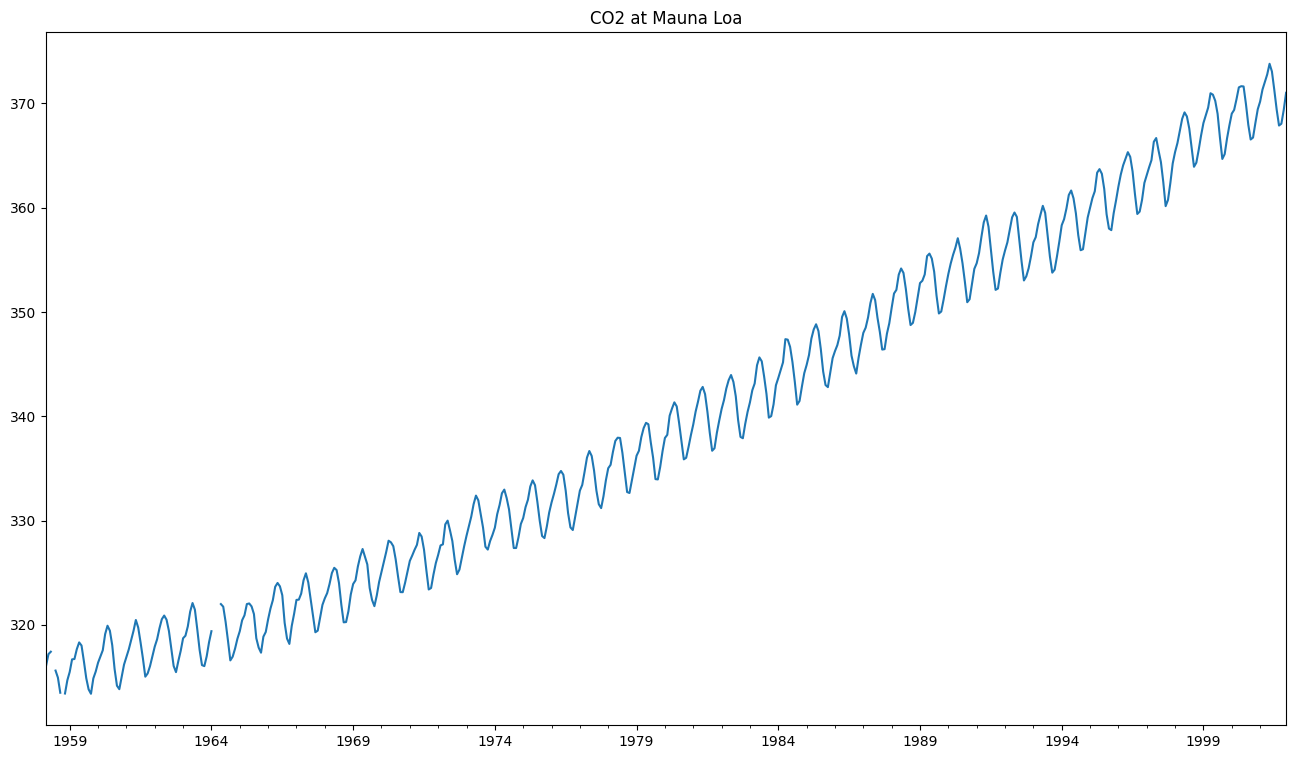

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

co2 = datas["co2"].resample("ME").mean()

fig, ax = plt.subplots()
co2.plot(ax=ax)

ax.set_title("CO2 at Mauna Loa")

We clearly see that there is both a trend and seasonality component in the data. The model seems to be additive as it doesn't grow/shrink with time. As such, let's set up our model

In [7]:
from numpyro.distributions import HalfNormal, Normal
import numpyro
from numpyro_sts import SmoothLocalLinearTrend, periodic, LocalLinearTrend, RandomWalk
import numpy as np

def model(n: int, y: np.ndarray = None, mask: bool = True, num_seasons: int = 12):
    # level component
    with numpyro.handlers.scope(prefix="level"):
        mean = np.nanmean(y[:10]) if y is not None else 0.0

        std = numpyro.sample("std", HalfNormal())
        drift = numpyro.sample("drift", Normal())
        x_0 = mean + numpyro.sample("x_0", Normal(scale=100.0))

        local_linear = RandomWalk(n, std, x_0, drift=drift)
        level = numpyro.sample("x", local_linear)

    # seasonality
    with numpyro.handlers.scope(prefix="seasonality"):
        std = numpyro.sample("std", HalfNormal())

        with numpyro.plate("factors", num_seasons - 1):
            x_0 = numpyro.sample("x_0", Normal())

        seasonality_model = periodic.SeasonalSeries(n, num_seasons, std, x_0)
        seasonality = numpyro.sample("x", seasonality_model)

    # observable
    std = numpyro.sample("std", HalfNormal())
    loc = level[..., 0] + seasonality[..., 0]

    with numpyro.handlers.mask(mask=mask):
        y_ = numpyro.sample("y", Normal(loc, std), obs=y)

    return

Since we have a fully probabilistic model, let's sample from the model and see it's outputs

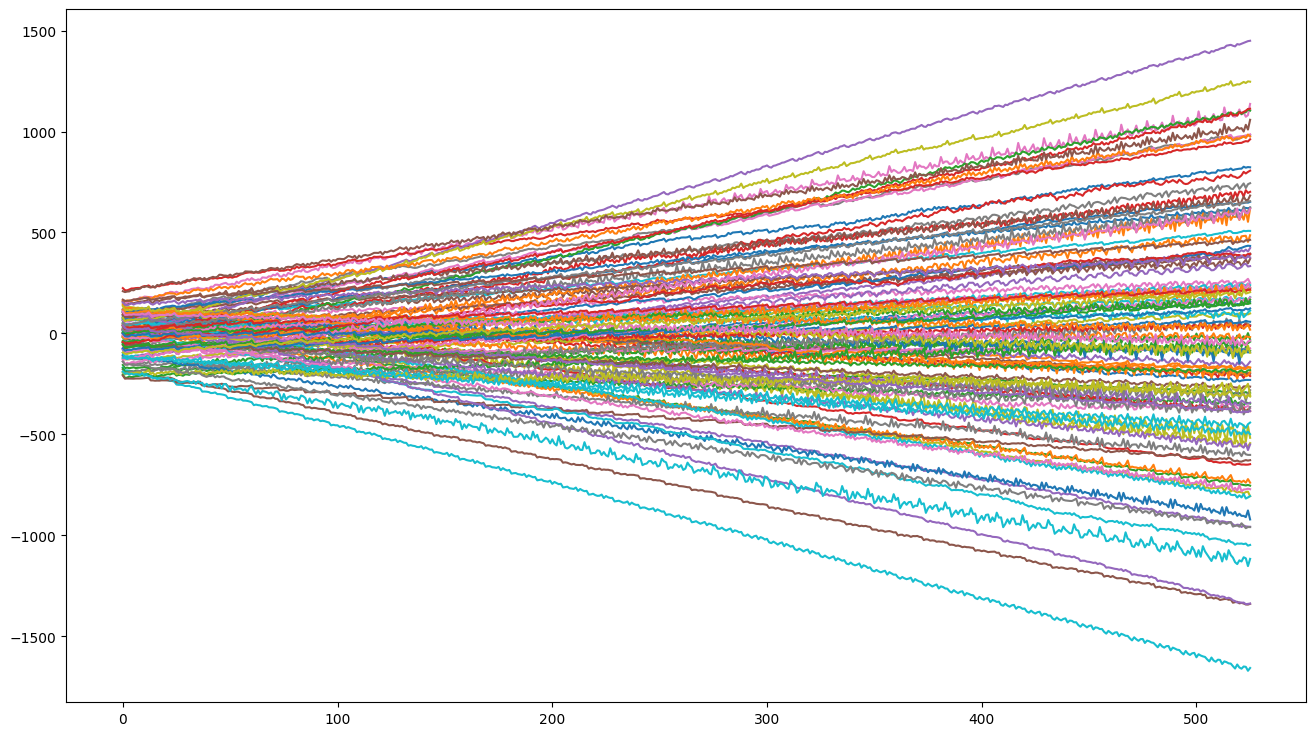

In [8]:
from numpyro.infer import Predictive
import jax.random as jrnd

predictive = Predictive(model, num_samples=100)
key = jrnd.PRNGKey(0)

samples = predictive(key, n=co2.shape[0])

fig, ax = plt.subplots()
ax.plot(samples["y"].swapaxes(0, -1))

Alright, let's perform some inference

In [ ]:
from numpyro.infer import NUTS, MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5_000, num_samples=1_000, num_chains=4, chain_method="parallel")
mcmc.run(key, n=co2.shape[0], y=co2.values, mask=np.isfinite(co2.values))

/var/folders/9b/lw4j5mg524q8vsr7yp3qwxv40000gn/T/ipykernel_5394/4184972365.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=5_000, num_samples=1_000, num_chains=4, chain_method="parallel")
warmup:   2%|▏         | 106/6000 [00:27<24:06,  4.07it/s, 1023 steps of size 3.02e-02. acc. prob=0.76]